## Calculating Kicks to Semimajor Axis

In this notebook, we simulate a close encounter between planets to determine the "kicks" to the semi-major axis at conjunction. We compare this numerical result with an analytical solution as derived by Namouni et al.

### Namouni's Analytical Result
As found in Namoni et al, the effective potential between two planets can be expanded in powers of eccentricity:

\begin{align}
    W = \sum_{q = -\infty}^{\infty} W_q e^{in(\lambda-\phi)}(-1)^q
\end{align}

The following values were found as the coefficients of this expansion:

In [17]:
W1 = 3.359
W2 = 2.678665722
W3 = 2.639498803
W4 = 2.8559

The kicks to semi-major axis at conjunction can be expressed using these coefficients as follows:

\begin{align}
    \frac{\Delta a_r}{a_0} = -\frac{8}{9} \frac{\mu}{e_c^2} \sum_{q=1}^{\infty} q \tilde{e}^q \sin{(q (\lambda - \varpi))} \lvert W_q \rvert
\end{align}

### Numerical Simulation

In [18]:
# Imports
import matplotlib.pyplot as plt
import rebound
import numpy as np

#### Constants and parameters

The setup consists of two planets in an MMR. We study the Hill approximation, the limit in which the planets are closely spaced and their mass is much smaller than that of the star. In our setup, the inner planet is massive and travels on a circular orbit, and the outer planet is a massless test particle travelling on a slightly eccentric orbit.

In [19]:
mu=3e-12 *125       # m_1/m_star
j, k = 100, 1       # j:j-k MMR
pomega = np.pi/2    # pericenter of outer test particle
phi = 2*np.pi/3     # Angle of conjunction relative to pericenter (resonant angle)

n = 2*np.pi         # mean motion of inner planet (is just 2*pi so period = 1)
n20 = n*(j-k)/j     # initial mean motion of outer particle (19/20*n) (at resonance value)
                    # completes 19 orbits in the same time the inner planet completes 20 orbits
dares = (j/(j-k))**(2/3)-1 # delta a_res-- distance between test particle and planet at resonance
deltan = 0          # delta n: deviation of mean motion from resonance
                    # this small value is added to n20 bc the planet isn't *exactly* at resonance

ec = 2*k/3/j        # crossing eccentricity, factor to normalize e
etilde = 0.1        # eccentricity ratio to crossing value (e/e_c)

e = etilde*ec       # eccentricity
deltat = 2/3/n20    # time to move delta a in y at a rate delta v, 
                    #   where v = a*delta_n and delta_n = n2-n1

tconj=j/k           # time between conjunctions

epsilon = (1/3*mu)**(1/3) # small mass parameter

### Setup

We initialize the simulation so that the conjunction occurs near t=0 and the specified conjunction angle, phi. We also define a function calc_Delta_a to find the change in relative semimajor axis $a$ from before and after the conjunction.

In [20]:
def setup(t0=-deltat, correction=0, phi=phi, etilde=etilde, theta=None, to_print=True): # make sim with sim.t = t0 (where conjunction always happens near t=0, use get_conjunction_time to get exact)
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1)
    sim.add(m=mu, P=1, 
            l=pomega+(phi-correction)+n*t0) # phi = l - pomega, so l = pomega+phi
    ps = sim.particles
    if theta is None:
        theta = pomega+(phi-correction)+n20*t0
    sim.add(P=2*np.pi/(n20+deltan), e=etilde*ec, pomega=pomega, l=theta)
    sim.t = t0
    
    if to_print:
        print('Hill radius separation:', (sim.particles[2].a-sim.particles[1].a)/(mu/3)**(1/3)) # , sim.particles[1].l
    return sim

def calculate_phi_correction(phi_0, etilde, tmin, tmax, Nout, iterations=3, to_print=False):
    #initializing
    correction = 0
    phi_err = 0

    # iterate to correct for phi value
    for iteration in range(iterations):
        # set up simulation
        phi_input = phi_0 - correction # phi value that goes into sim
        sim = setup(t0 = tmin, phi = phi_input, etilde = etilde, to_print=False)
        ps = sim.particles

        # integrate through conjunction
        dl, phi_arr = np.zeros(Nout), np.zeros(Nout)
        times = np.linspace(tmin, tmax, Nout)
        for i, time in enumerate(times):
            sim.integrate(time)
            dl[i] = unwrap_l(ps)
            phi_arr[i] = ps[2].l - ps[2].pomega

        # find simulated phi conjunction, compare to input vlaue
        conj_idx = np.argmin(np.abs(dl))
        correction = phi_arr[conj_idx] - phi_input
        phi_err = phi_arr[conj_idx] - phi_0

    if to_print:
        print('{:9}: {}'.format('Input phi', phi_0))
        print('{:9}: {}'.format('Sim phi', phi_arr[conj_idx]))
        
    return correction, phi_err # (correction angle and the deviation from the actual phi)
    

def calc_Delta_a(da_list, conj_idx):
    '''returns change in da from before to after conjunction given list of a values 
       throughout conj'''
    da0_max_idx = np.argmax(da_list[:conj_idx]) # max value of a before conjunction, 
                                              # corresponds to peak just before conj

    daf_max_idx = (np.argmax(da_list[conj_idx:]) # max value of a after conjunction 
                   + conj_idx)                    

    da0 = np.mean(da_list[:da0_max_idx])
    daf = np.mean(da_list[daf_max_idx:])

    Delta_a = daf-da0

    return Delta_a, da0, daf

def unwrap_l(ps):
    if ps[2].l - ps[1].l > np.pi:
        return ps[2].l - ps[1].l - 2*np.pi
    elif ps[2].l - ps[1].l < -np.pi:
        return ps[2].l - ps[1].l + 2*np.pi
    else:
        return ps[2].l - ps[1].l

As an example, we can integrate through a close encounter event and plot the semimajor axis throughout this process to visualize the kick it experiences at conjunction.

Input phi: 2.0943951023931953
Sim phi  : 2.0943962902793345
Hill radius separation: 13.445441239247286


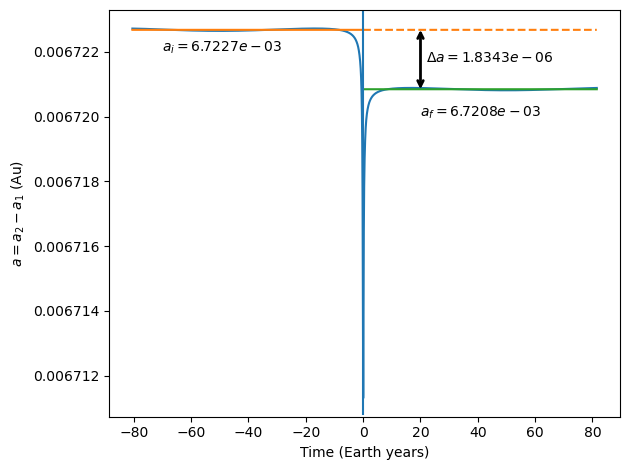

In [22]:
Nout = 20000
tmin = -0.805*tconj 
tmax = 0.815*tconj  
correction, phi_err = calculate_phi_correction(phi, etilde, tmin, tmax, Nout, iterations=3, to_print=True)
sim = setup(t0=tmin, correction=correction)
ps = sim.particles

da, dl, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times = np.linspace(tmin, tmax, Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    da[i] = ps[2].a - ps[1].a
    dl[i] = unwrap_l(ps)
    phi_arr[i] = ps[2].l - ps[2].pomega
    
# conjunction index, angle at conjunction
conj_idx = np.argmin(np.abs(dl))
_, da0_plot, daf_plot = calc_Delta_a(da, conj_idx)

# plot da throughout encounter
fig, ax = plt.subplots()
ax.plot(times, da)
t_before_conj = times[:conj_idx]
t_after_conj = times[conj_idx:]
ax.plot(t_before_conj, np.ones_like(t_before_conj)*da0_plot, label='pre-conjunction')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*da0_plot, c='C1', linestyle='--')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*daf_plot, label='post-conjunction')
ax.axvline(times[conj_idx], da[conj_idx]) # conjunction location
ax.annotate('$a_i={:.4e}$'.format(da0_plot), (-70, .006722))
ax.annotate('$a_f={:.4e}$'.format(daf_plot), (20, .006720))
ax.annotate("", (20, da0_plot), (20, daf_plot), arrowprops={'arrowstyle':'<->','shrinkA':0, 'shrinkB':0,'linewidth':2, 'color':'black'})
ax.annotate('$\Delta a={:.4e}$'.format(da0_plot-daf_plot), (22, .0067217))
ax.set(xlabel='Time (Earth years)', ylabel='$a = a_2 - a_1$ (Au)') #title='Evolution of Relative Semimajor Axis during Conjunction')
#ax.legend()
fig.tight_layout()
fig.savefig('delta_a.pdf')

We repeat this process for a range of initial eccentricity values for the test particle's orbit and compare the numerical simulation result to Namoni's result.

In [23]:
Nout = 100000 # num time steps in integration
N = 10 #
etilde_list = np.linspace(0.001, .2, N)
a_kicks, paper_1, paper_2, paper_3, paper_4 = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
for idx, etilde in enumerate(etilde_list):
    #setup
    e = etilde*ec
    correction, phi_err = calculate_phi_correction(phi, etilde, tmin, tmax, Nout, iterations=2)
    sim = setup(t0=tmin, correction=correction, etilde=etilde)
    ps = sim.particles

    # integration
    da, dl, phi_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(tmin, tmax, Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        da[i] = ps[2].a - ps[1].a
        dl[i] = unwrap_l(ps) # removes 2*pi jumps in dl
        phi_arr[i] = ps[2].l - ps[2].pomega
    
    # conjunction index, angle at conjunction
    conj_idx = np.argmin(np.abs(dl))

    theta = phi_arr[conj_idx] # angle at conjunction
    print(theta)

    # n-body solution
    Delta_a, da0, daf = calc_Delta_a(da, conj_idx)
    
    #delta_a = daf - da0
    a_kicks[idx] = Delta_a / ps[1].a

    # Namouni solution
    paper_1[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1) # 1st order approx
    paper_2[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2) # 2nd order approx
    paper_3[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta)) # 3rd order approx
    paper_4[idx] = -8/9 * mu / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta) + 4*W4*etilde**4*np.sin(4*theta)) # 4th order approx

Input phi: 2.0943951023931953
Sim phi  : -0.9404872184200701
Hill radius separation: 13.44544123924773
4.120113036549411
Input phi: 2.0943951023931953
Sim phi  : 2.09202918493646
Hill radius separation: 13.44544123924773
2.0945078623152513
Input phi: 2.0943951023931953
Sim phi  : 2.0937291320331344
Hill radius separation: 13.445441239248174
2.09440957256468
Input phi: 2.0943951023931953
Sim phi  : 2.094074864765988
Hill radius separation: 13.44544123924773
2.094399339347157
Input phi: 2.0943951023931953
Sim phi  : 2.094205369884432
Hill radius separation: 13.445441239248618
2.094396822314371
Input phi: 2.0943951023931953
Sim phi  : 2.0942695914454936
Hill radius separation: 13.445441239248174
2.0943959343765113
Input phi: 2.0943951023931953
Sim phi  : 2.0943062130597596
Hill radius separation: 13.445441239248174
2.094395551790046
Input phi: 2.0943951023931953
Sim phi  : 2.09432912937197
Hill radius separation: 13.445441239248174
2.09439536457014
Input phi: 2.0943951023931953
Sim phi  :

Comparison of results from Namouni and n-body simulation:

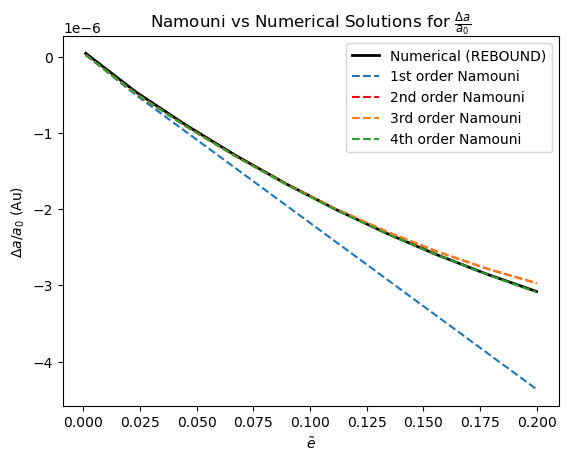

In [24]:
fig, ax = plt.subplots()
ax.plot(etilde_list, a_kicks, 'k-', linewidth=2, label='Numerical (REBOUND)')
ax.plot(etilde_list, paper_1, '--', label='1st order Namouni')
ax.plot(etilde_list, paper_2, '--', label='2nd order Namouni', c='red')
ax.plot(etilde_list, paper_3, '--', label='3rd order Namouni')
ax.plot(etilde_list, paper_4, '--', label='4th order Namouni')
#ax.set_xlim(0, 0.08)
#ax.set_ylim(-1.6*1e-6, 0.05*1e-6)
ax.set(xlabel="$\\tilde{e}$", ylabel='$\Delta a$/$a_0$ (Au)', title='Namouni vs Numerical Solutions for $\\frac{\Delta a}{a_0}$')

ax.legend()
#fig.savefig('comp_plot.pdf') # pdf
fig.savefig('comp_plot.png', dpi=300) # png
